In [27]:
!python -V
!pip install seaborn torch
#!python -m pip install seaborn
#!python3 -m pip install seaborn

Python 3.8.5
Defaulting to user installation because normal site-packages is not writeable


In [28]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [5]:
df = pd.read_csv("/home/poki/Documents/pokerai-master/dataset.csv")
df.head()

,hand_id,street,player_position,players_in_pot,after_us_decision_players,current_pot_size,player_stack_size,percent_deposited_of_current_stack,pay_for_continue_play,current_bet,...,board_6_amount,board_5_amount,board_4_amount,board_3_amount,board_2_amount,board_spades_amount,board_hearts_amount,board_diamonds_amount,board_clubs_amount,ready_combination
0,2dgVE9A320200916155222_1,PREFLOP,2,0,4,15.0,2217.25,0.00000,10.0,10.0,...,0,0,0,0,0,0,0,0,0,AIR
1,2dgVE9A320200916155222_2,PREFLOP,4,1,4,36.3,2217.25,0.00000,21.3,21.3,...,0,0,0,0,0,0,0,0,0,AIR
2,2dgVE9A320200916155222_3,PREFLOP,5,1,3,45.0,2217.25,0.00000,30.0,30.0,...,0,0,0,0,0,0,0,0,0,AIR
3,2dgVE9A320200916155222_4,PREFLOP,0,0,1,15.0,2217.25,0.00225,5.0,10.0,...,0,0,0,0,0,0,0,0,0,AIR
4,2dgVE9A320200916155222_5,PREFLOP,1,1,1,40.0,2237.25,0.00445,15.0,25.0,...,0,0,0,0,0,0,0,0,0,AIR


<AxesSubplot:xlabel='action', ylabel='count'>

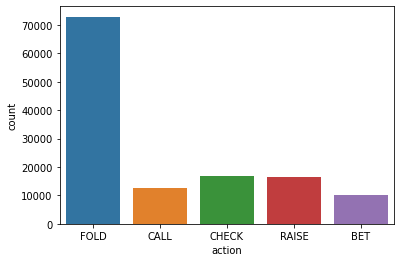

In [6]:
sns.countplot(x = 'action', data=df)

In [7]:
class2idx = {
    "FOLD":0,
    "RAISE":1,
    "CHECK":2,
    "BET":3,
    "CALL":4,
}
idx2class = {v: k for k, v in class2idx.items()}
df['action'].replace(class2idx, inplace=True)

In [8]:
y = df['action'].values
X = df.drop(columns=['action', 'hand_id']).iloc[:]

enc = OrdinalEncoder()
X = enc.fit_transform(X)
#print(enc.categories_)

# Split into train+val and test
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=69)

# Split train into train-val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, stratify=y_trainval, random_state=21)

In [12]:
df.head()

,hand_id,street,player_position,players_in_pot,after_us_decision_players,current_pot_size,player_stack_size,percent_deposited_of_current_stack,pay_for_continue_play,current_bet,...,board_6_amount,board_5_amount,board_4_amount,board_3_amount,board_2_amount,board_spades_amount,board_hearts_amount,board_diamonds_amount,board_clubs_amount,ready_combination
0,2dgVE9A320200916155222_1,PREFLOP,2,0,4,15.0,2217.25,0.00000,10.0,10.0,...,0,0,0,0,0,0,0,0,0,AIR
1,2dgVE9A320200916155222_2,PREFLOP,4,1,4,36.3,2217.25,0.00000,21.3,21.3,...,0,0,0,0,0,0,0,0,0,AIR
2,2dgVE9A320200916155222_3,PREFLOP,5,1,3,45.0,2217.25,0.00000,30.0,30.0,...,0,0,0,0,0,0,0,0,0,AIR
3,2dgVE9A320200916155222_4,PREFLOP,0,0,1,15.0,2217.25,0.00225,5.0,10.0,...,0,0,0,0,0,0,0,0,0,AIR
4,2dgVE9A320200916155222_5,PREFLOP,1,1,1,40.0,2237.25,0.00445,15.0,25.0,...,0,0,0,0,0,0,0,0,0,AIR


In [9]:
#Scale data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

In [10]:
def get_class_distribution(obj):
    count_dict = {
        "FOLD":0,
        "RAISE":0,
        "CHECK":0,
        "BET":0,
        "CALL":0,
    }

    for i in obj:
        if i == 0:
            count_dict['FOLD'] += 1
        elif i == 1:
            count_dict['RAISE'] += 1
        elif i == 2:
            count_dict['CHECK'] += 1
        elif i == 3: 
            count_dict['BET'] += 1
        elif i == 4: 
            count_dict['CALL'] += 1           
        else:
            print("Check classes.")
            
    return count_dict

Text(0.5, 1.0, 'Class Distribution in Test Set')

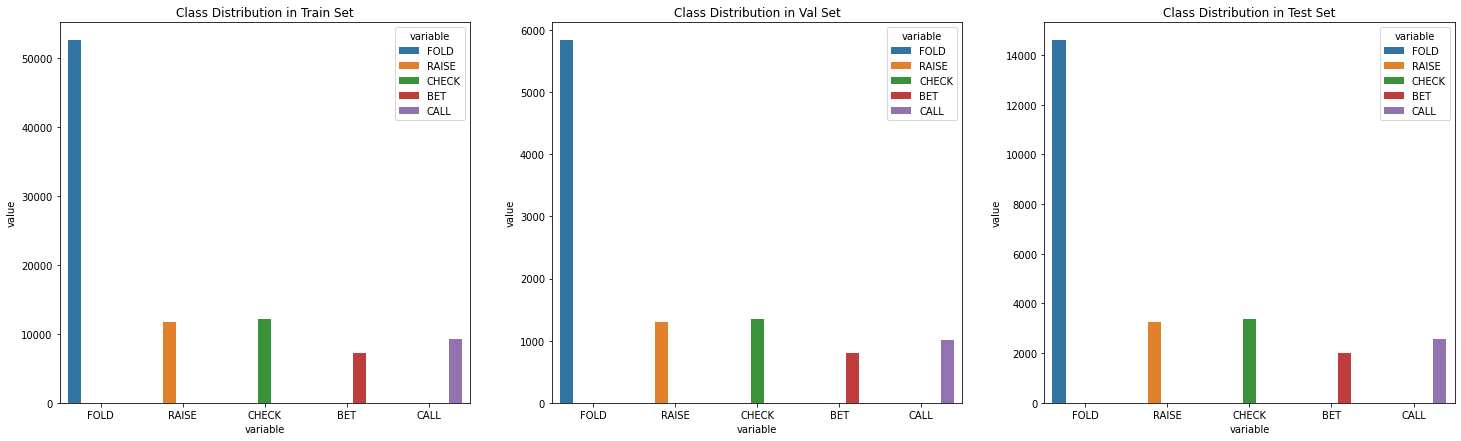

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,7))# Train
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_train)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[0]).set_title('Class Distribution in Train Set')# Validation
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_val)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[1]).set_title('Class Distribution in Val Set')# Test
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_test)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[2]).set_title('Class Distribution in Test Set')

In [16]:
class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_dataset = ClassifierDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
test_dataset = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

In [24]:
print(train_dataset)

In [20]:
target_list = []
for _, t in train_dataset:
    target_list.append(t)
    
target_list = torch.tensor(target_list)
target_list = target_list[torch.randperm(len(target_list))]

In [29]:
print(target_list)

tensor([4, 4, 4,  ..., 0, 1, 1])


In [30]:
class_count = [i for i in get_class_distribution(y_train).values()]
class_weights = 1./torch.tensor(class_count, dtype=torch.float)
print(class_weights)

tensor([1.9045e-05, 8.5034e-05, 8.2196e-05, 1.3822e-04, 1.0898e-04])


In [31]:
class_weights_all = class_weights[target_list]

In [32]:
weighted_sampler = WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)

In [44]:
EPOCHS = 300
BATCH_SIZE = 16
LEARNING_RATE = 0.0007

NUM_FEATURES = len(X.columns)
NUM_CLASSES = 5

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [37]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          sampler=weighted_sampler
)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [38]:
class MulticlassClassification(nn.Module):
    
    
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 512)
        self.layer_2 = nn.Linear(512, 128)
        self.layer_3 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, num_class) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(64)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_out(x)
        
        return x

In [40]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


/home/poki/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [43]:
model = MulticlassClassification(num_feature = NUM_FEATURES, num_class = NUM_CLASSES)
model.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
print(model)


NameError: name 'NUM_FEATURES' is not defined